# Trotterization and Operator Splitting

Recall the form of our Hamiltonian,

$$\hat{H} = \frac{\hat{p}^2}{2m} + V(\hat{x}),$$

and our time evolution unitary,

$$\hat{U} = \exp(-i\hat{H}t/\hbar),$$

which we want to approximate. Now in $\hat{H}$, the kinetic energy term is only dependent on $\hat{p}$ and the potential energy term is only dependent on $\hat{x}$. Naturally, we might consider splitting the Hamiltonian, since if we express our quantum state in terms of the $p$ and then the $x$ basis before doing each transformation, we could get away with only using diagonal operators. But in general,

$$\exp(A+B) \neq \exp(A)\exp(B)$$

if $A$ and $B$ do not commute. However, we can still split the operator if we reduce the error by a method called trotterization, in which we make the approximation

$$e^{A+B} \approx e^{A/2}e^Be^{A/2}. $$

Full details of the error and the motivation for this approximation are given in the Appendix at the bottom of this notebook, but are omitted here so that we can get to the methods as quickly as possible.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library import QFT

Remember that we'll be switching between the $p$ and $x$ in order to allow $\exp\left(\frac{-i\hat{p}^2}{2m\hbar}\Delta t\right)$ and $\exp\left(\frac{-iV(\hat{x})}{\hbar}\Delta t\right)$ to be diagonalizable. Therefore, we'll perform Fourier transforms in between.

<img src=trotter_creditPeterLove.png>

Before we test this, we must create a circuit. We'll choose the potential of the harmonic oscillator, $V(x) = \frac{1}{2}m\omega^2x^2$. For simplicity, let's choose $m=1/2$ and $\omega=2$. Therefore, we have $V(x) = x^2$. In fact, we may as well use [Hartree units](https://en.wikipedia.org/wiki/Hartree_atomic_units) all the way through so that $\hbar=1$ as well.

In [2]:
def swap_QFT(qc, target_qubits, inverse=False):
    """Qiskit's QFT function is currently not doing swaps as we want it to, so we use this function."""
    num_qubits = len(target_qubits)
    if inverse:
        qc.append(QFT(num_qubits=num_qubits, do_swaps=False, inverse=True), target_qubits)
        for i in range(num_qubits//2):
            qc.swap(target_qubits[i], target_qubits[num_qubits-1-i])
    else:
        for i in range(num_qubits//2):
            qc.swap(target_qubits[i], target_qubits[num_qubits-1-i])
        qc.append(QFT(num_qubits=num_qubits, do_swaps=False, inverse=False), target_qubits)

We borrow the unitary generator from diagonal.ipynb, with some of my own modifications.

In [3]:
def unitary_f(in_qubits, out_qubits, f, name=None):
    """Returns a gate that transforms |in>|out> into |in>|f(in)+out> base 2."""
    qc = QuantumCircuit(in_qubits, out_qubits)
    num_in_qubits = len(in_qubits)
    num_out_qubits = len(out_qubits)
    for x in range(2**num_in_qubits):
        xbstr = format(x, f'0{num_in_qubits}b')[::-1]
        zeros = [in_qubits[i] for i in range(len(xbstr)) if xbstr[i]=='0']
       
        fx = f(x)
        fxbstr = format(fx, f'0{num_out_qubits}b')[::-1]
        fones = [out_qubits[j] for j in range(len(fxbstr)) if fxbstr[j]=='1']
        
        qc.x(zeros)
        for target_qubit in fones:
            qc.mcx(in_qubits[:], target_qubit)
        qc.x(zeros)
            
        U_f = qc.to_gate()
        if name is not None:
            U_f.name = name
        return U_f

Since we want to have both halves of our harmonic oscillator, let us center it. Because we are using 5 qubits, our domain and range are integers in the interval $[0, 31]$. Therefore, we use the potential
$$ V(x) = (x - 15)^2$$

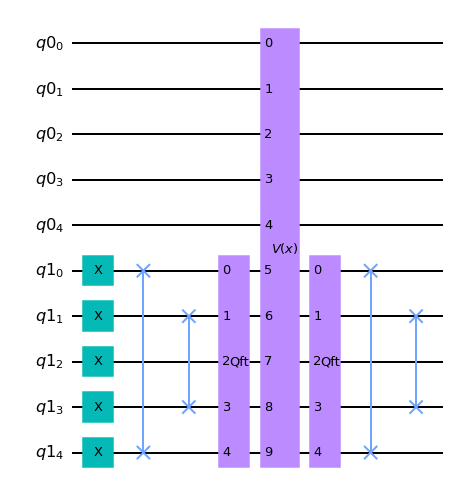

In [4]:
def exp_unitary_f(qc, in_qubits, aux_qubits, f, name=None):
    #aux_qubits MUST be previously initialized at |111...111>
    swap_QFT(qc, aux_qubits, inverse=False)
    qc.append(unitary_f(in_qubits, aux_qubits, f, name=name), in_qubits[:]+aux_qubits[:])
    swap_QFT(qc, aux_qubits, inverse=True)
    
    
n = 5
state_V = QuantumRegister(n)
aux_V = QuantumRegister(n)
qc_V = QuantumCircuit(state_V, aux_V)

qc_V.x(aux_V)
#Since exp_unitary_f really applies a factor of exp(-i2pi*f(x)),
# we need to divide by 6, our best approximation to 2pi.
exp_unitary_f(qc_V, state_V, aux_V, lambda x:(x-15)**2 //6 % 2**n, name=r"$V(x)$")

qc_V.draw(output='mpl')

Let us make a similar circuit for the kinetic energy $T = p^2/2m$. Since we chose $m=1/2$ earlier, this is just $T(p) = p^2$

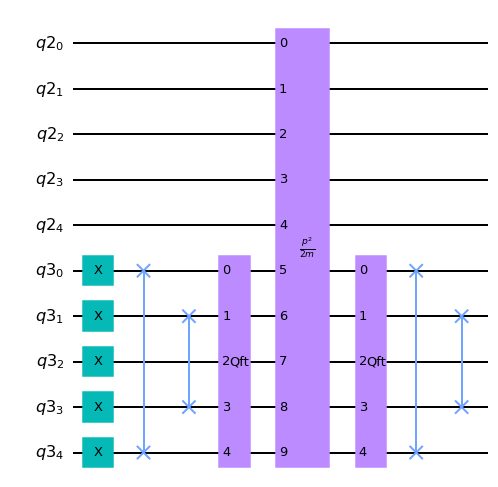

In [5]:
#Kinetic energy circuit qc_T
state_T = QuantumRegister(n)
aux_T = QuantumRegister(n)
qc_T = QuantumCircuit(state_T, aux_T)

qc_T.x(aux_T)
exp_unitary_f(qc_T, state_T, aux_T, lambda p:p**2 % 2**n, name=r"$\frac{p^2}{2m}$")

qc_T.draw(output='mpl')

Now that we know how our process will go, we can Trotterize.

In [6]:
def second_order_trotter_Hamiltonian(qc, T, V, state_qubits, aux_qubits):
    """Second-order Trotterization for the evolution of a state.
    
    Args:
        qc: QuantumCircuit instance
        T, V: Functions for T with respect to p and V with respect to x mod 2**len(aux_qubits)
        state_qubits: qubits storing the state of the wavefunction
        aux_qubits: auxiliary qubits, with number num_out_qubits as in unitary_f"""
    
    num_in = len(state_qubits)
    num_out = len(aux_qubits)
    exp_unitary_f(qc, state, aux, lambda p:T(p)// 2 % 2**num_out, name=r"$\frac{p^2}{4m}$")
    qc.barrier()
    swap_QFT(qc, state_qubits, inverse=False)
    qc.barrier()
    exp_unitary_f(qc, state, aux, lambda x:V(x) % 2**num_out, name=r"$V(x)$")
    qc.barrier()
    swap_QFT(qc, state_qubits, inverse=True)
    qc.barrier()
    exp_unitary_f(qc, state, aux, lambda p:T(p)// 2 % 2**num_out, name=r"$\frac{p^2}{4m}$")

Here, we build the completed circuit. We only apply QFT on the state qubits when transforming between the $p$ and $x$ basis because the auxilliary qubits need to be kept in the state $\left|{11111}\right\rangle$. Also note that we start off in the $p$ basis.

In [22]:
state = QuantumRegister(n)
aux = QuantumRegister(n)
c = ClassicalRegister(n)
qc = QuantumCircuit(state, aux, c)

#Potential energy V(x).
def potential(x):
    return (x-15)**2

#Kinetic energy T(p). Recall that we chose m=1/2, and T=p^2/(2m).
def kinetic(p):
    return p**2

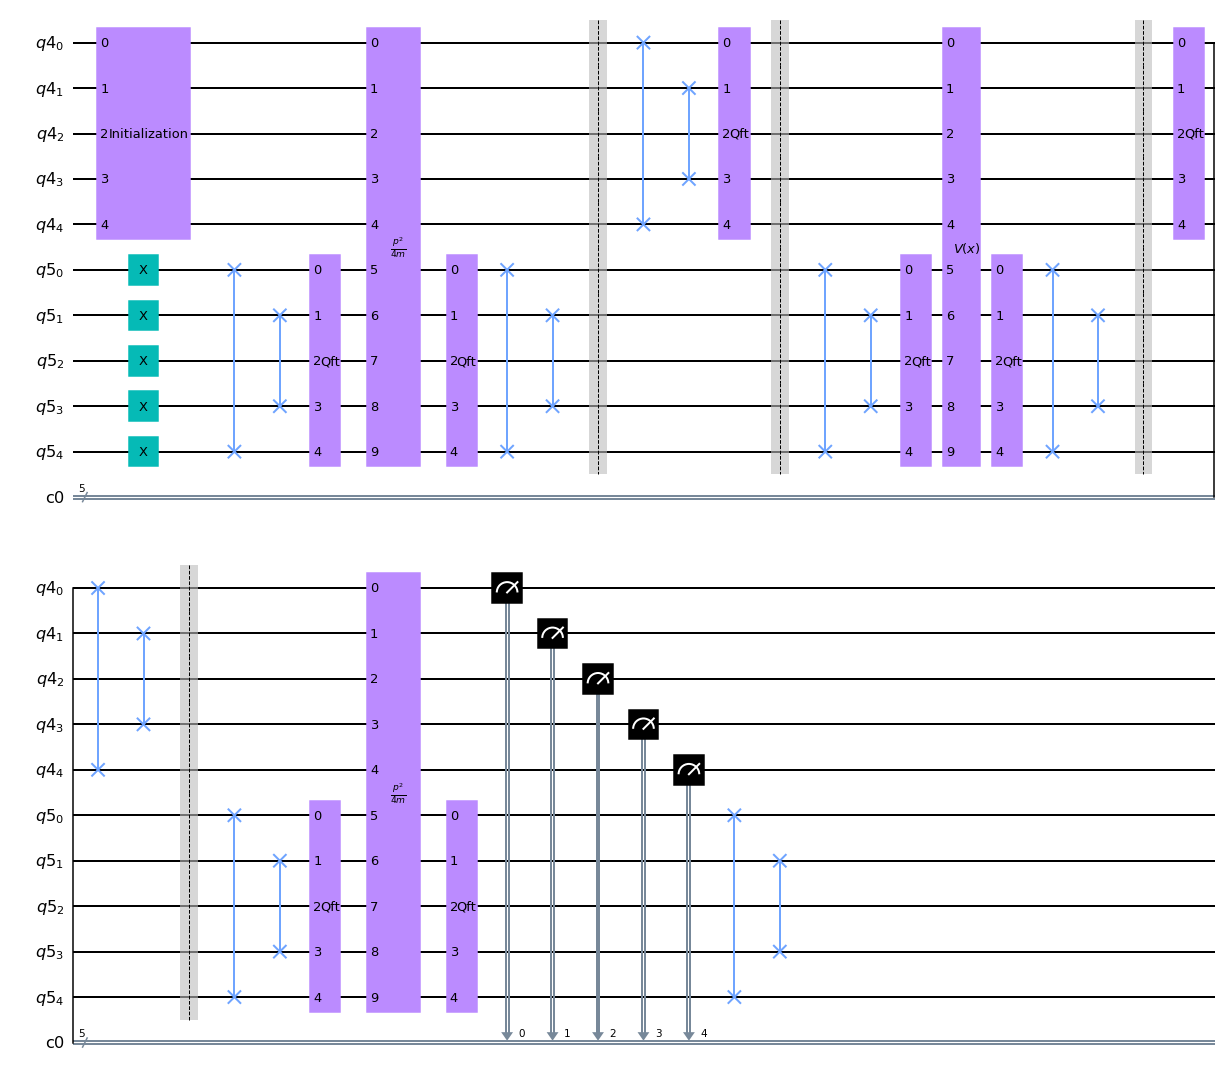

In [9]:
qc = QuantumCircuit(state, aux, c)
qc.x(aux[:])
second_order_trotter_Hamiltonian(qc, potential, kinetic, state, aux)
qc.measure(state, c)
qc.draw('mpl')

Note that in general, when we have $H = \sum^m_{k=1} H_k$, the Trotter expansion is

$$ e^{-iHt} \approx \left(\prod^m_{k=1}e^{-iH_{m-k+1}\Delta_t/2} \prod^m_{k=1}e^{-iH_k\Delta_t/2}\right)^N, ~\Delta_t = t/N.$$

## Appendix: Error of the Approximation
Much of this content was taken from Peter Love's presentation at the Duke summer school.

In general,

$$\exp(A+B) \neq \exp(A)\exp(B)$$

if $A$ and $B$ do not commute. But how do they differ? Let's look at an operator $\hat{U}$:

\begin{align}
    \hat{U} &= \exp((A+B)t) = \sum^{\infty}_{n=0}\frac{(A+B)^n}{n!}t^n\\
     &= 1 + (A+B)t + \frac{(A+B)^2}{2}t^2 + \cdots
\end{align}

Compare this to the approximation $\tilde{U}$:

\begin{align}
     \tilde{U} &= \exp(At)\exp(Bt) = \left(\sum^{\infty}_{n=0}\frac{A^n}{n!}t^n\right)\left(\sum^{\infty}_{n=0}\frac{B^n}{n!}t^n\right)\\
    &= \left(1+At+\frac{A^2}{2}t^2+\cdots\right)\left(1+Bt+\frac{B^2}{2}t^2+\cdots\right)\\
     &= 1 + (A+B)t + \frac{A^2+AB+B^2}{2} + \cdots
\end{align}

Looking at the difference between $\tilde{U}$ and $\hat{U}$ up to only the second order terms, we have

\begin{align}
    \tilde{U} &= \hat{U} - \frac{BAt^2}{2} + \frac{ABt^2}{2} + \cdots\\
     &= \hat{U} + \frac{[A,B]t^2}{2} + \cdots
\end{align}

where $[A,B]$ is the called the commutator, and is defined as $[A,B] = AB - BA$.

We could keep doing this to higher order terms; these are described by the [Baker-Campbell-Hausdorff formula](https://en.wikipedia.org/wiki/Baker%E2%80%93Campbell%E2%80%93Hausdorff_formula).
Now how do we get our second-order errors to cancel out? We can try to approximate $e^{A+B}$ with

$$e^{A/2}e^Be^{A/2}.$$

First, the error from the right two terms, $e^C \equiv e^Be^{A/2}$:

$$ C = \log(e^Be^{A/2}) = \frac{A}{2} + B+ \frac{[B,A]}{4} + \frac{[B,[B,A]}{24} + \frac{[A,[A,B]}{48} + \cdots$$

Then we include the $e^{A/2}$ term that was on the left:

\begin{align}
    \log(e^{A/2}e^C) &= \frac{A}{2} + C + \frac{[A,C]}{4} + \frac{[A,[A,C]}{48} + \frac{[C,[C,A]}{24} + \cdots \\
    &= A+B + \frac{[B,A]}{4}+\frac{[A,B]}{4} + \cdots \\
    &= A + B - \frac{[B,[A,B]]}{12} - \frac{[A,[A,B]]}{24}+ \cdots,
\end{align}

where in the last step we used the property that $[A,B] = -[B,A]$. And we have successfully eliminated our 2nd-order error terms.